<a href="https://colab.research.google.com/github/sv9-ru/flow_meter/blob/main/%D1%81%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [ ]:
!pip install pandas openpyxl requestsdf.describedf.describe
!pip install hyperopt scikit-optimize

ERROR: Could not find a version that satisfies the requirement requestsdf.describedf.describe (from versions: none)
ERROR: No matching distribution found for requestsdf.describedf.describe
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


# Выгрузка и подготовка данных

In [ ]:
# Шаг 1: Загрузка данных
url = "https://cmfdata.susu.ru/uploads/5~1580896402-card/dataset1_full.xlsx"
try:
    df = pd.read_excel(url, sheet_name='AllData', skiprows=3)
    print("Данные успешно загружены по URL.")
except Exception as e:
    print(f"Ошибка загрузки по URL: {e}.")

Данные успешно загружены по URL.


In [ ]:
df

,Unnamed: 0,[kg/s],[kg/s].1,[kg/m3],Unnamed: 4,[kg/s].2,[kg/m3].1,[%],[%].1,[%].2,[%].3
0,NaN,0.400000,0.388189,881.985773,0.000000,0.382319,882.351249,-0.041438,-1.512080,0.041438,0.041438
1,NaN,0.400000,0.394546,864.927467,1.937404,0.372571,870.716319,1.272146,-5.569839,0.669288,0.661934
2,NaN,0.400000,0.395661,839.054391,4.878619,0.374177,853.636886,3.202944,-5.429938,1.737968,1.664638
3,NaN,0.400000,0.384471,793.836315,10.024014,0.349452,826.056071,6.324710,-9.108449,4.058741,3.669721
4,NaN,0.400000,0.380295,750.509635,14.956647,0.332518,801.325179,9.124674,-12.563232,6.770805,5.782158
...,...,...,...,...,...,...,...,...,...,...,...
98,NaN,3.198919,3.198517,787.076997,10.718202,3.133618,780.669167,11.405913,-2.029058,-0.814130,-0.645108
99,NaN,3.198919,3.203326,741.856139,15.870485,3.115105,740.097075,16.011433,-2.754035,-0.237117,-0.123463
100,NaN,3.198919,3.206674,697.252279,20.954153,3.104561,700.877401,20.464128,-3.184391,0.519915,0.481051
101,NaN,3.198919,3.210449,655.637726,25.698116,3.052219,664.833119,24.556245,-4.928577,1.402511,1.107213


In [ ]:
df.dropna(axis=1, how='all', inplace=True)
df = df.iloc[3:].reset_index(drop=True)
df.columns = ['Nominal Mass Flow [kg/s]', 'Ref Mass Flow [kg/s]', 'Ref Density [kg/m3]', 'GVF [%]',
              'Cor Mass Flow [kg/s]', 'Cor Density [kg/m3]', 'Cor Density Drop [%]',
              'Err Mass Flow [%]', 'Err Density [%]', 'Err Density Drop [%]']

X = df[['Cor Mass Flow [kg/s]', 'Cor Density Drop [%]']].values
y_mf = df['Err Mass Flow [%]'].values
y_rho = df['Err Density [%]'].values

In [ ]:
df

,Nominal Mass Flow [kg/s],Ref Mass Flow [kg/s],Ref Density [kg/m3],GVF [%],Cor Mass Flow [kg/s],Cor Density [kg/m3],Cor Density Drop [%],Err Mass Flow [%],Err Density [%],Err Density Drop [%]
0,0.400000,0.384471,793.836315,10.024014,0.349452,826.056071,6.324710,-9.108449,4.058741,3.669721
1,0.400000,0.380295,750.509635,14.956647,0.332518,801.325179,9.124674,-12.563232,6.770805,5.782158
2,0.400000,0.397907,713.282956,19.191395,0.342740,779.530997,11.588791,-13.864100,9.287765,7.538822
3,0.400000,0.392152,669.935472,24.125027,0.322958,756.400543,14.204524,-17.644719,12.906477,9.837848
4,0.400000,0.387429,537.322375,39.224030,0.262435,692.248388,21.463929,-32.262282,28.832973,17.614184
...,...,...,...,...,...,...,...,...,...,...
95,3.198919,3.198517,787.076997,10.718202,3.133618,780.669167,11.405913,-2.029058,-0.814130,-0.645108
96,3.198919,3.203326,741.856139,15.870485,3.115105,740.097075,16.011433,-2.754035,-0.237117,-0.123463
97,3.198919,3.206674,697.252279,20.954153,3.104561,700.877401,20.464128,-3.184391,0.519915,0.481051
98,3.198919,3.210449,655.637726,25.698116,3.052219,664.833119,24.556245,-4.928577,1.402511,1.107213


#Посторение графиков

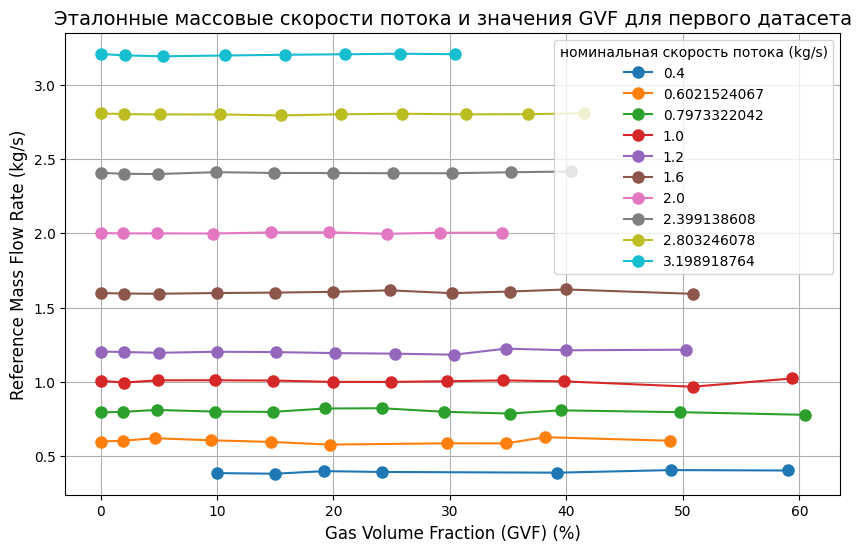

In [ ]:
plt.figure(figsize=(10, 6))

# Сортируем данные по оси X для правильного соединения линий
df1_sorted = df.sort_values('GVF [%]')

# Рисуем линии с маркерами для каждой группы
for name, group in df1_sorted.groupby('Nominal Mass Flow [kg/s]'):
    plt.plot(group['GVF [%]'], group['Ref Mass Flow [kg/s]'],
             marker='o',  # добавляем точки
             linestyle='-',  # сплошная линия
             markersize=8,  # размер точек
             label=name)  # легенда

plt.title('Эталонные массовые скорости потока и значения GVF для первого датасета', fontsize=14)
plt.xlabel('Gas Volume Fraction (GVF) (%)', fontsize=12)
plt.ylabel('Reference Mass Flow Rate (kg/s)', fontsize=12)
plt.legend(title='номинальная скорость потока (kg/s)')
plt.grid(True)
plt.savefig('ms_gvf_df1.png', dpi=300, bbox_inches='tight')
plt.show()

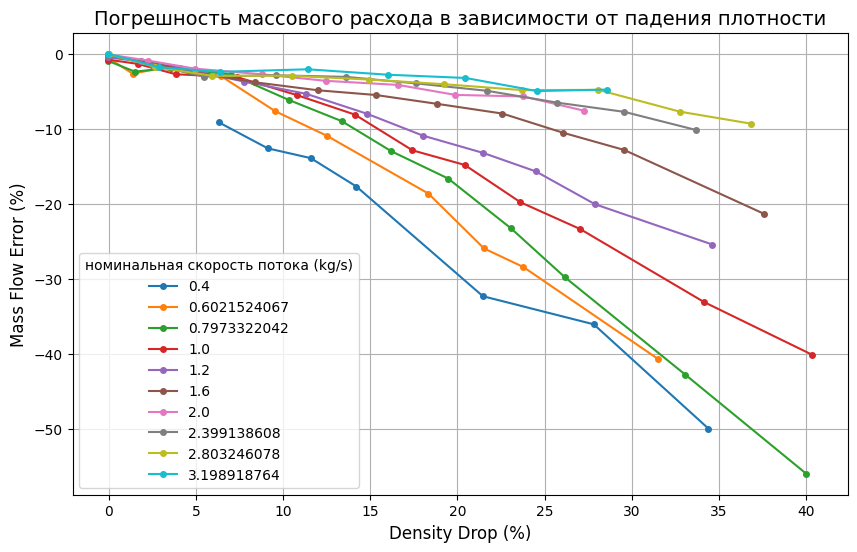

In [ ]:
plt.figure(figsize=(10, 6))

# Сортируем данные по оси X для правильного соединения линий
df1_sorted = df.sort_values('Cor Density Drop [%]')

# Рисуем линии с маркерами для каждой группы
for name, group in df1_sorted.groupby('Nominal Mass Flow [kg/s]'):
    plt.plot(group['Cor Density Drop [%]'], group['Err Mass Flow [%]'],
             marker='o',  # добавляем точки
             linestyle='-',  # сплошная линия
             markersize=4,  # размер точек
             label=name)  # легенда

plt.title('Погрешность массового расхода в зависимости от падения плотности', fontsize=14)
plt.xlabel('Density Drop (%)', fontsize=12)
plt.ylabel('Mass Flow Error (%)', fontsize=12)
plt.legend(title='номинальная скорость потока (kg/s)')
plt.grid(True)
plt.savefig('ms_gvf_df1.png', dpi=300, bbox_inches='tight')
plt.show()

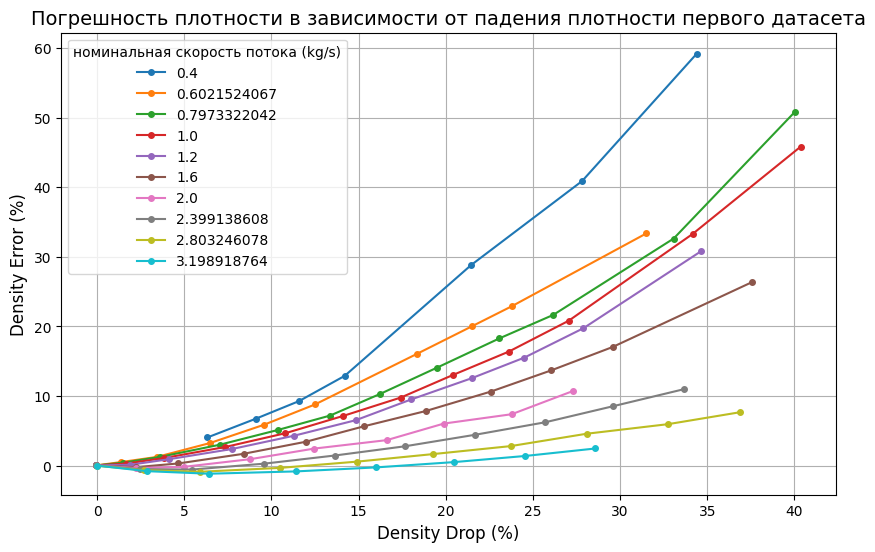

In [ ]:
plt.figure(figsize=(10, 6))

# Сортируем данные по оси X для правильного соединения линий
df1_sorted = df.sort_values('Cor Density Drop [%]')

# Рисуем линии с маркерами для каждой группы
for name, group in df1_sorted.groupby('Nominal Mass Flow [kg/s]'):
    plt.plot(group['Cor Density Drop [%]'], group['Err Density [%]'],
             marker='o',  # добавляем точки
             linestyle='-',  # сплошная линия
             markersize=4,  # размер точек
             label=name)  # легенда

plt.title('Погрешность плотности в зависимости от падения плотности первого датасета', fontsize=14)
plt.xlabel('Density Drop (%)', fontsize=12)
plt.ylabel('Density Error (%)', fontsize=12)
plt.legend(title='номинальная скорость потока (kg/s)')
plt.grid(True)
plt.savefig('ms_gvf_df1.png', dpi=300, bbox_inches='tight')
plt.show()

# Метрические методы

### Подбор гипер параметров

In [ ]:
# Функция для сплита (80/20)
def manual_train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_size = int(len(indices) * test_size)
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx], test_idx

X_train, X_test, y_mf_train, y_mf_test, test_idx = manual_train_test_split(X, y_mf)
_, _, y_rho_train, y_rho_test, _ = manual_train_test_split(X, y_rho)

m_true_test = df['Ref Mass Flow [kg/s]'].values[test_idx]
rho_true_test = df['Ref Density [kg/m3]'].values[test_idx]
m_obs_test = X_test[:, 0]
rho_obs_test = df['Cor Density [kg/m3]'].values[test_idx]

# Нормализация с использованием StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
# Шаг 3: KNN функция
def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    for x in X_test:
        distances = np.linalg.norm(X_train - x, axis=1)
        nearest = np.argsort(distances)[:k]
        pred = np.mean(y_train[nearest])
        predictions.append(pred)
    return np.array(predictions)

In [ ]:
# Шаг 4: Подбор K (1-15)
ks = range(1, 16)
results = []
for k in ks:
    # Для массового расхода
    pred_mf = knn_predict(X_train_norm, y_mf_train, X_test_norm, k)
    corrected_m = m_obs_test / (1 + pred_mf / 100)
    rmse_m = np.sqrt(np.mean((corrected_m - m_true_test)**2))
    mae_m = np.mean(np.abs(corrected_m - m_true_test))

    # Для плотности
    pred_rho = knn_predict(X_train_norm, y_rho_train, X_test_norm, k)
    corrected_rho = rho_obs_test / (1 + pred_rho / 100)
    rmse_rho = np.sqrt(np.mean((corrected_rho - rho_true_test)**2))
    mae_rho = np.mean(np.abs(corrected_rho - rho_true_test))

    results.append({'K': k, 'RMSE Mass Flow': rmse_m, 'MAE Mass Flow': mae_m,
                    'RMSE Density': rmse_rho, 'MAE Density': mae_rho})

# Вывод результатов в таблице
results_df = pd.DataFrame(results)
display(results_df)

# Лучшие K (по минимальному RMSE)
best_k_m = results_df.loc[results_df['RMSE Mass Flow'].idxmin()]['K']
best_k_rho = results_df.loc[results_df['RMSE Density'].idxmin()]['K']
print(f"Лучшее K для коррекции массового расхода: {best_k_m}")
print(f"Лучшее K для коррекции плотности: {best_k_rho}")

,K,RMSE Mass Flow,MAE Mass Flow,RMSE Density,MAE Density
0,1,0.044262,0.028087,12.422772,8.370570
1,2,0.016620,0.013602,10.938953,7.750518
2,3,0.016566,0.011436,9.968808,5.191975
3,4,0.026560,0.013632,11.117565,5.858460
4,5,0.028174,0.015361,12.258733,5.965530
5,6,0.038913,0.018848,12.265508,6.031150
6,7,0.028735,0.017191,8.727843,5.151829
7,8,0.021165,0.014419,8.632000,4.485572
8,9,0.023339,0.017085,10.198046,6.171986
9,10,0.022163,0.015965,10.495305,5.921705


Лучшее K для коррекции массового расхода: 3.0
Лучшее K для коррекции плотности: 8.0


In [ ]:
# Подготовка данных
X = df[['Cor Mass Flow [kg/s]', 'Cor Density Drop [%]']].values
y_mf = df['Err Mass Flow [%]'].values
y_rho = df['Err Density [%]'].values
m_obs = df['Cor Mass Flow [kg/s]'].values
m_true = df['Ref Mass Flow [kg/s]'].values
rho_obs = df['Cor Density [kg/m3]'].values
rho_true = df['Ref Density [kg/m3]'].values

# Разбиение данных (80/20) с согласованными индексами
X_train, X_test, y_mf_train, y_mf_test, y_rho_train, y_rho_test, \
m_obs_train, m_obs_test, m_true_train, m_true_test, \
rho_obs_train, rho_obs_test, rho_true_train, rho_true_test = train_test_split(
    X, y_mf, y_rho, m_obs, m_true, rho_obs, rho_true,
    test_size=0.2, random_state=42)

# Нормализация с использованием StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Функция KNN
def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    for x in X_test:
        distances = np.linalg.norm(X_train - x, axis=1)
        nearest = np.argsort(distances)[:k]
        pred = np.mean(y_train[nearest])
        predictions.append(pred)
    return np.array(predictions)

# Оптимальные K (на основе предыдущих результатов)
k_m = 2  # Для Mass Flow
k_rho = 8  # Для Density

## KNN

Результаты модели KNN (K=2 для Mass Flow, K=8 для Density):


,Metric,Mass Flow (kg/s),Density (kg/m³)
0,MSE,0.000276,74.511419
1,RMSE,0.016620,8.632000
2,MAE,0.013602,4.485572
3,MAPE,1.489496,0.741208


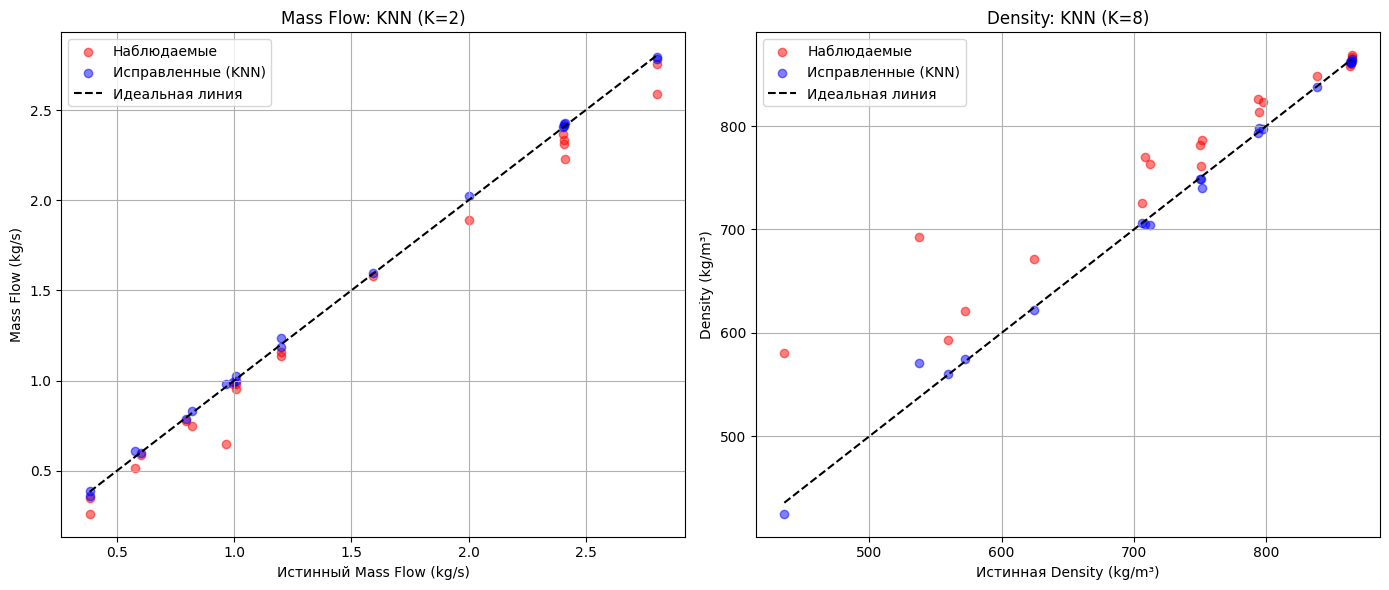

Параметры модели для использования: {'k_mass_flow': 2, 'k_density': 8, 'scaler_mean': array([ 1.48736329, 16.19930162]), 'scaler_scale': array([ 0.90643788, 11.26766415])}


In [ ]:
# Функция KNN
def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    for x in X_test:
        distances = np.linalg.norm(X_train - x, axis=1)
        nearest = np.argsort(distances)[:k]
        pred = np.mean(y_train[nearest])
        predictions.append(pred)
    return np.array(predictions)

# Модель для Mass Flow
pred_mf = knn_predict(X_train_norm, y_mf_train, X_test_norm, k_m)
corrected_m = m_obs_test / (1 + pred_mf / 100)
mse_m = np.mean((corrected_m - m_true_test)**2)
rmse_m = np.sqrt(mse_m)
mae_m = np.mean(np.abs(corrected_m - m_true_test))
mape_m = np.mean(np.abs((corrected_m - m_true_test) / m_true_test)) * 100

# Модель для Density
pred_rho = knn_predict(X_train_norm, y_rho_train, X_test_norm, k_rho)
corrected_rho = rho_obs_test / (1 + pred_rho / 100)
mse_rho = np.mean((corrected_rho - rho_true_test)**2)
rmse_rho = np.sqrt(mse_rho)
mae_rho = np.mean(np.abs(corrected_rho - rho_true_test))
mape_rho = np.mean(np.abs((corrected_rho - rho_true_test) / rho_true_test)) * 100

# Вывод результатов
results = {
'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE'],
'Mass Flow (kg/s)': [mse_m, rmse_m, mae_m, mape_m],
'Density (kg/m³)': [mse_rho, rmse_rho, mae_rho, mape_rho]
}
results_df = pd.DataFrame(results)
print(f"Результаты модели KNN (K={k_m} для Mass Flow, K={k_rho} для Density):")
display(results_df)

# Графики: истинные vs исправленные значения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mass Flow
ax1.scatter(m_true_test, m_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax1.scatter(m_true_test, corrected_m, color='blue', label='Исправленные (KNN)', alpha=0.5)
ax1.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--', label='Идеальная линия')
ax1.set_xlabel('Истинный Mass Flow (kg/s)')
ax1.set_ylabel('Mass Flow (kg/s)')
ax1.set_title(f'Mass Flow: KNN (K={k_m})')
ax1.legend()
ax1.grid(True)

# Density
ax2.scatter(rho_true_test, rho_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax2.scatter(rho_true_test, corrected_rho, color='blue', label='Исправленные (KNN)', alpha=0.5)
ax2.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--', label='Идеальная линия')
ax2.set_xlabel('Истинная Density (kg/m³)')
ax2.set_ylabel('Density (kg/m³)')
ax2.set_title(f'Density: KNN (K={k_rho})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Сохранение параметров модели
model_params = {
    'k_mass_flow': k_m,
    'k_density': k_rho,
    'scaler': scaler
}
print("Параметры модели для использования:", {
    'k_mass_flow': model_params['k_mass_flow'],
    'k_density': model_params['k_density'],
    'scaler_mean': model_params['scaler'].mean_,
    'scaler_scale': model_params['scaler'].scale_
})

##Взвешенный KNN

Результаты взвешенной модели KNN (K=2 для Mass Flow, K=8 для Density):


,Metric,Mass Flow (kg/s),Density (kg/m³)
0,MSE,0.000294,76.626536
1,RMSE,0.017159,8.753658
2,MAE,0.013873,4.383010
3,MAPE,1.553234,0.727827


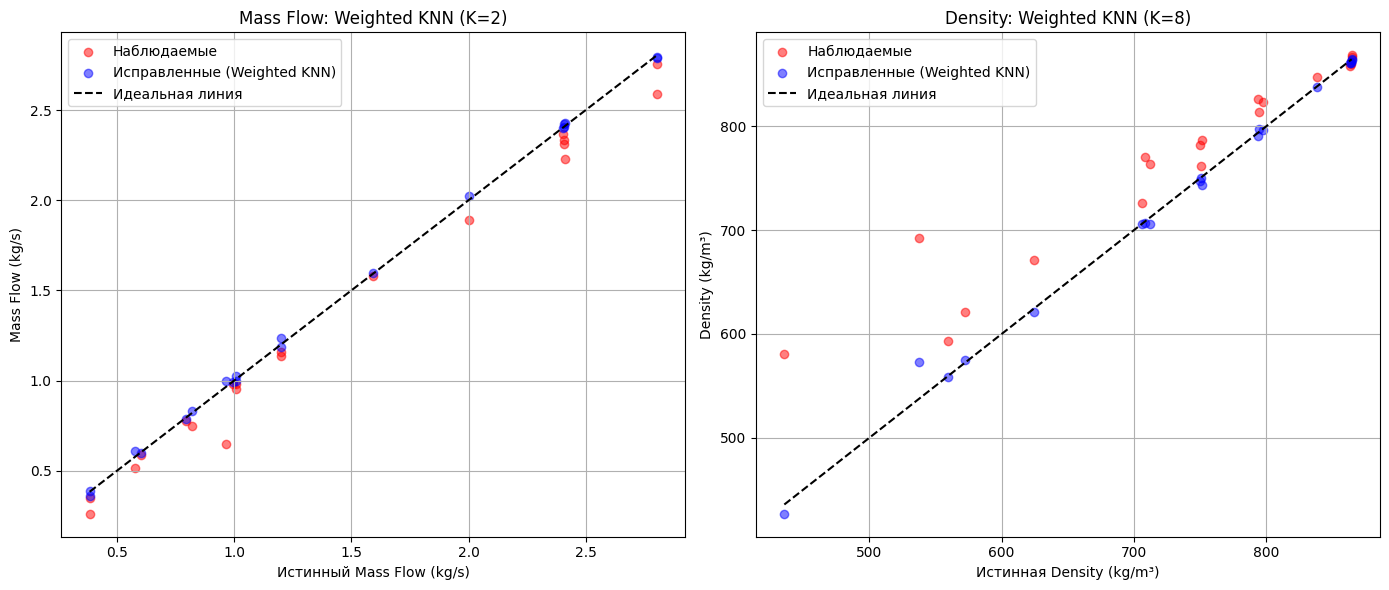

Параметры модели для использования: {'k_mass_flow': 2, 'k_density': 8, 'scaler_mean': array([ 1.48736329, 16.19930162]), 'scaler_scale': array([ 0.90643788, 11.26766415])}


In [ ]:

# Функция взвешенного KNN
def knn_predict_weighted(X_train, y_train, X_test, k, epsilon=1e-6):
    predictions = []
    for x in X_test:
        distances = np.linalg.norm(X_train - x, axis=1)
        nearest = np.argsort(distances)[:k]
        weights = 1 / (distances[nearest] + epsilon)  # Вес = 1/(расстояние + epsilon)
        weighted_pred = np.sum(y_train[nearest] * weights) / np.sum(weights)
        predictions.append(weighted_pred)
    return np.array(predictions)

# Модель для Mass Flow
pred_mf = knn_predict_weighted(X_train_norm, y_mf_train, X_test_norm, k_m)
corrected_m = m_obs_test / (1 + pred_mf / 100)
mse_m = np.mean((corrected_m - m_true_test)**2)
rmse_m = np.sqrt(mse_m)
mae_m = np.mean(np.abs(corrected_m - m_true_test))
mape_m = np.mean(np.abs((corrected_m - m_true_test) / m_true_test)) * 100

# Модель для Density
pred_rho = knn_predict_weighted(X_train_norm, y_rho_train, X_test_norm, k_rho)
corrected_rho = rho_obs_test / (1 + pred_rho / 100)
mse_rho = np.mean((corrected_rho - rho_true_test)**2)
rmse_rho = np.sqrt(mse_rho)
mae_rho = np.mean(np.abs(corrected_rho - rho_true_test))
mape_rho = np.mean(np.abs((corrected_rho - rho_true_test) / rho_true_test)) * 100

# Вывод результатов
results = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE'],
    'Mass Flow (kg/s)': [mse_m, rmse_m, mae_m, mape_m],
    'Density (kg/m³)': [mse_rho, rmse_rho, mae_rho, mape_rho]
}
results_df = pd.DataFrame(results)
print(f"Результаты взвешенной модели KNN (K={k_m} для Mass Flow, K={k_rho} для Density):")
display(results_df)

# Графики: истинные vs исправленные значения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mass Flow
ax1.scatter(m_true_test, m_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax1.scatter(m_true_test, corrected_m, color='blue', label='Исправленные (Weighted KNN)', alpha=0.5)
ax1.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--', label='Идеальная линия')
ax1.set_xlabel('Истинный Mass Flow (kg/s)')
ax1.set_ylabel('Mass Flow (kg/s)')
ax1.set_title(f'Mass Flow: Weighted KNN (K={k_m})')
ax1.legend()
ax1.grid(True)

# Density
ax2.scatter(rho_true_test, rho_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax2.scatter(rho_true_test, corrected_rho, color='blue', label='Исправленные (Weighted KNN)', alpha=0.5)
ax2.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--', label='Идеальная линия')
ax2.set_xlabel('Истинная Density (kg/m³)')
ax2.set_ylabel('Density (kg/m³)')
ax2.set_title(f'Density: Weighted KNN (K={k_rho})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Сохранение параметров модели
model_params = {
    'k_mass_flow': k_m,
    'k_density': k_rho,
    'scaler': scaler
}
print("Параметры модели для использования:", {
    'k_mass_flow': model_params['k_mass_flow'],
    'k_density': model_params['k_density'],
    'scaler_mean': model_params['scaler'].mean_,
    'scaler_scale': model_params['scaler'].scale_
})

## ядераня

Результаты Kernel Regression для разных ядер:


,Kernel,MSE Mass Flow,RMSE Mass Flow,MAE Mass Flow,MAPE Mass Flow,MSE Density,RMSE Density,MAE Density,MAPE Density
0,rectangular,0.000600,0.024495,0.019540,2.206342,204.728536,14.308338,9.041988,1.381181
1,triangular,0.000360,0.018969,0.014199,1.711809,129.131719,11.363614,6.196524,0.973030
2,gaussian,0.002726,0.052207,0.044579,3.985753,604.525875,24.587108,21.162350,3.065158


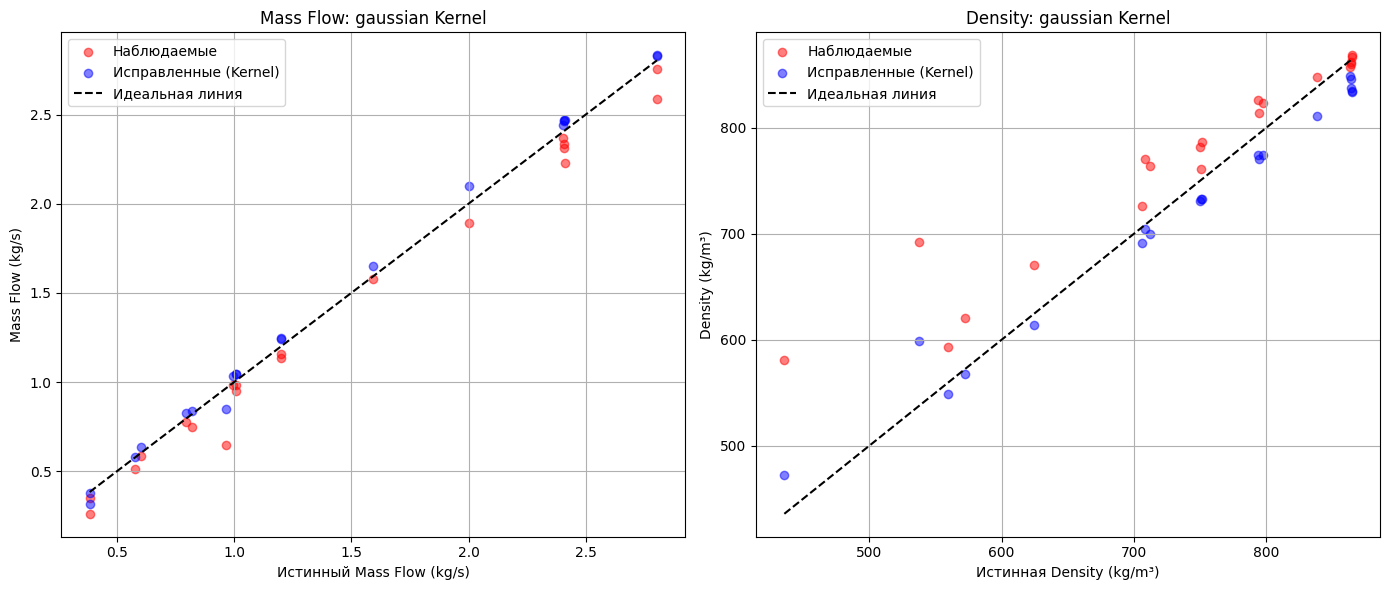

In [ ]:
# Нормализация с использованием StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Функция для вычисления весов для разных ядер
def kernel_weights(dist, h, kernel_type):
    u = dist / h
    if kernel_type == 'rectangular':
        return np.where(np.abs(u) <= 1, 1, 0)
    elif kernel_type == 'triangular':
        return np.where(np.abs(u) <= 1, (1 - np.abs(u)), 0)
    elif kernel_type == 'gaussian':
        return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
    else:
        raise ValueError("Unsupported kernel type")

# Функция для kernel regression
def kernel_regression_predict(X_train, y_train, X_test, h, kernel_type):
    predictions = []
    for x in X_test:
        dist = np.linalg.norm(X_train - x, axis=1)
        weights = kernel_weights(dist, h, kernel_type)
        if np.sum(weights) > 0:
            pred = np.sum(weights * y_train) / np.sum(weights)
        else:
            pred = np.mean(y_train)  # fallback if no points in bandwidth
        predictions.append(pred)
    return np.array(predictions)

# Bandwidth h (гиперпараметр, подбирается, здесь примерные значения на основе данных)
h = 1.0  # Можно подбирать, например, через CV, но для примера фиксируем

# Ядра
kernels = ['rectangular', 'triangular', 'gaussian']

# Результаты для каждого ядра
results_list = []

for kernel_type in kernels:
    # Для Mass Flow
    pred_mf = kernel_regression_predict(X_train_norm, y_mf_train, X_test_norm, h, kernel_type)
    corrected_m = m_obs_test / (1 + pred_mf / 100)
    mse_m = np.mean((corrected_m - m_true_test)**2)
    rmse_m = np.sqrt(mse_m)
    mae_m = np.mean(np.abs(corrected_m - m_true_test))
    mape_m = np.mean(np.abs((corrected_m - m_true_test) / m_true_test)) * 100

    # Для Density
    pred_rho = kernel_regression_predict(X_train_norm, y_rho_train, X_test_norm, h, kernel_type)
    corrected_rho = rho_obs_test / (1 + pred_rho / 100)
    mse_rho = np.mean((corrected_rho - rho_true_test)**2)
    rmse_rho = np.sqrt(mse_rho)
    mae_rho = np.mean(np.abs(corrected_rho - rho_true_test))
    mape_rho = np.mean(np.abs((corrected_rho - rho_true_test) / rho_true_test)) * 100

    results_list.append({
        'Kernel': kernel_type,
        'MSE Mass Flow': mse_m,
        'RMSE Mass Flow': rmse_m,
        'MAE Mass Flow': mae_m,
        'MAPE Mass Flow': mape_m,
        'MSE Density': mse_rho,
        'RMSE Density': rmse_rho,
        'MAE Density': mae_rho,
        'MAPE Density': mape_rho
    })

results_df = pd.DataFrame(results_list)
print("Результаты Kernel Regression для разных ядер:")
display(results_df)

# Графики для gaussian ядра (как пример)
kernel_type = 'gaussian'
pred_mf = kernel_regression_predict(X_train_norm, y_mf_train, X_test_norm, h, kernel_type)
corrected_m = m_obs_test / (1 + pred_mf / 100)
pred_rho = kernel_regression_predict(X_train_norm, y_rho_train, X_test_norm, h, kernel_type)
corrected_rho = rho_obs_test / (1 + pred_rho / 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mass Flow
ax1.scatter(m_true_test, m_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax1.scatter(m_true_test, corrected_m, color='blue', label='Исправленные (Kernel)', alpha=0.5)
ax1.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--', label='Идеальная линия')
ax1.set_xlabel('Истинный Mass Flow (kg/s)')
ax1.set_ylabel('Mass Flow (kg/s)')
ax1.set_title(f'Mass Flow: {kernel_type} Kernel')
ax1.legend()
ax1.grid(True)

# Density
ax2.scatter(rho_true_test, rho_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax2.scatter(rho_true_test, corrected_rho, color='blue', label='Исправленные (Kernel)', alpha=0.5)
ax2.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--', label='Идеальная линия')
ax2.set_xlabel('Истинная Density (kg/m³)')
ax2.set_ylabel('Density (kg/m³)')
ax2.set_title(f'Density: {kernel_type} Kernel')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## k-d деревья (без ядер)

Результаты KNN с K-d-деревом (K=3 для Mass Flow, K=8 для Density):


,Metric,Mass Flow (kg/s),Density (kg/m³)
0,MSE,0.000274,74.511419
1,RMSE,0.016566,8.632000
2,MAE,0.011436,4.485572
3,MAPE,1.416536,0.741208


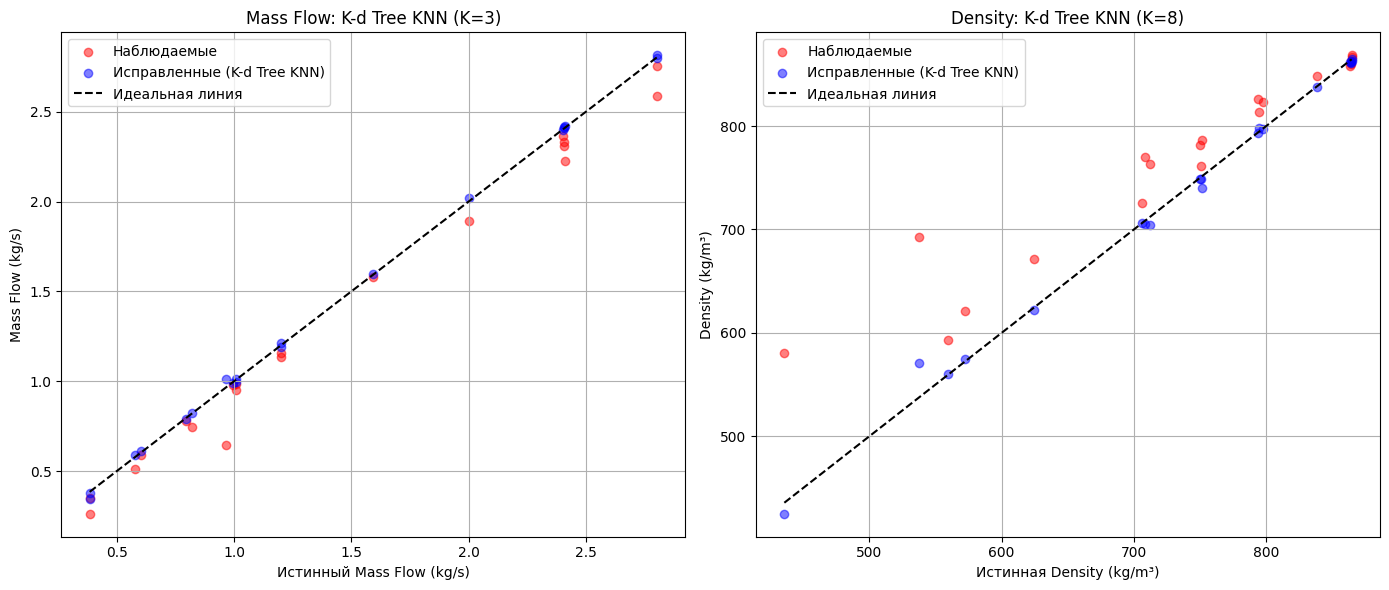

Параметры модели для использования: {'k_mass_flow': 3, 'k_density': 8, 'scaler_mean': array([ 1.48736329, 16.19930162]), 'scaler_scale': array([ 0.90643788, 11.26766415])}


In [ ]:
# Функция KNN с K-d-деревом (без ядер)
def knn_predict_kdtree(X_train, y_train, X_test, k):
    tree = KDTree(X_train)
    predictions = []
    for x in X_test:
        dist, idx = tree.query(x, k=k)
        pred = np.mean(y_train[idx])  # Среднее по K соседям (равные веса)
        predictions.append(pred)
    return np.array(predictions)

# Оптимальные K (на основе предыдущих результатов)
k_m = 3  # Для Mass Flow
k_rho = 8  # Для Density

# Модель для Mass Flow
pred_mf = knn_predict_kdtree(X_train_norm, y_mf_train, X_test_norm, k_m)
corrected_m = m_obs_test / (1 + pred_mf / 100)
mse_m = np.mean((corrected_m - m_true_test)**2)
rmse_m = np.sqrt(mse_m)
mae_m = np.mean(np.abs(corrected_m - m_true_test))
mape_m = np.mean(np.abs((corrected_m - m_true_test) / m_true_test)) * 100

# Модель для Density
pred_rho = knn_predict_kdtree(X_train_norm, y_rho_train, X_test_norm, k_rho)
corrected_rho = rho_obs_test / (1 + pred_rho / 100)
mse_rho = np.mean((corrected_rho - rho_true_test)**2)
rmse_rho = np.sqrt(mse_rho)
mae_rho = np.mean(np.abs(corrected_rho - rho_true_test))
mape_rho = np.mean(np.abs((corrected_rho - rho_true_test) / rho_true_test)) * 100

# Вывод результатов
results = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE'],
    'Mass Flow (kg/s)': [mse_m, rmse_m, mae_m, mape_m],
    'Density (kg/m³)': [mse_rho, rmse_rho, mae_rho, mape_rho]
}
results_df = pd.DataFrame(results)
print(f"Результаты KNN с K-d-деревом (K={k_m} для Mass Flow, K={k_rho} для Density):")
display(results_df)

# Графики: истинные vs исправленные значения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mass Flow
ax1.scatter(m_true_test, m_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax1.scatter(m_true_test, corrected_m, color='blue', label='Исправленные (K-d Tree KNN)', alpha=0.5)
ax1.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--', label='Идеальная линия')
ax1.set_xlabel('Истинный Mass Flow (kg/s)')
ax1.set_ylabel('Mass Flow (kg/s)')
ax1.set_title(f'Mass Flow: K-d Tree KNN (K={k_m})')
ax1.legend()
ax1.grid(True)

# Density
ax2.scatter(rho_true_test, rho_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax2.scatter(rho_true_test, corrected_rho, color='blue', label='Исправленные (K-d Tree KNN)', alpha=0.5)
ax2.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--', label='Идеальная линия')
ax2.set_xlabel('Истинная Density (kg/m³)')
ax2.set_ylabel('Density (kg/m³)')
ax2.set_title(f'Density: K-d Tree KNN (K={k_rho})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Сохранение параметров модели
model_params = {
    'k_mass_flow': k_m,
    'k_density': k_rho,
    'scaler': scaler
}
print("Параметры модели для использования:", {
    'k_mass_flow': model_params['k_mass_flow'],
    'k_density': model_params['k_density'],
    'scaler_mean': model_params['scaler'].mean_,
    'scaler_scale': model_params['scaler'].scale_
})

## K-d деревья

Результаты взвешенного KNN с K-d-деревом для разных ядер:


,Kernel,MSE Mass Flow,RMSE Mass Flow,MAE Mass Flow,MAPE Mass Flow,MSE Density,RMSE Density,MAE Density,MAPE Density
0,rectangular,0.000274,0.016566,0.011436,1.416536,74.511419,8.632000,4.485572,0.741208
1,triangular,0.000269,0.016405,0.011438,1.389141,78.916964,8.883522,4.612596,0.772443
2,gaussian,0.000272,0.016506,0.011427,1.409868,75.535451,8.691113,4.470298,0.741923


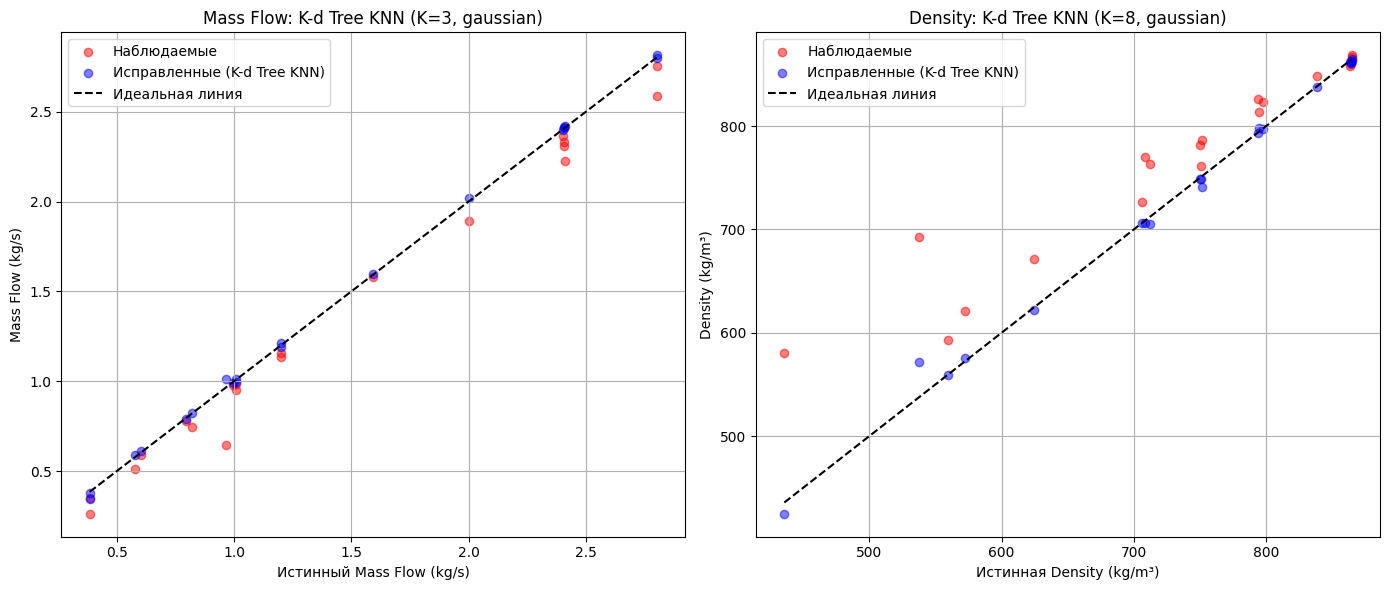

Параметры модели для использования: {'k_mass_flow': 3, 'k_density': 8, 'kernel_type': 'gaussian', 'bandwidth': 1.0, 'scaler_mean': array([ 1.48736329, 16.19930162]), 'scaler_scale': array([ 0.90643788, 11.26766415])}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree
from IPython.display import display
import matplotlib.pyplot as plt

# Функция для вычисления весов для разных ядер
def kernel_weights(dist, h, kernel_type):
    u = dist / h
    if kernel_type == 'rectangular':
        return np.where(np.abs(u) <= 1, 1, 0)
    elif kernel_type == 'triangular':
        return np.where(np.abs(u) <= 1, (1 - np.abs(u)), 0)
    elif kernel_type == 'gaussian':
        return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
    else:
        raise ValueError("Unsupported kernel type")

# Функция взвешенного KNN с K-d-деревом
def knn_predict_kdtree(X_train, y_train, X_test, k, kernel_type='gaussian', h=1.0, epsilon=1e-6):
    tree = KDTree(X_train)
    predictions = []
    for x in X_test:
        dist, idx = tree.query(x, k=k)
        weights = kernel_weights(dist, h, kernel_type)
        if np.sum(weights) > 0:
            pred = np.sum(y_train[idx] * weights) / np.sum(weights)
        else:
            pred = np.mean(y_train)  # Fallback если веса нулевые
        predictions.append(pred)
    return np.array(predictions)

# Ядра для тестирования
kernels = ['rectangular', 'triangular', 'gaussian']
results_list = []

# Bandwidth h (примерное значение, можно подбирать через CV)
h = 1.0

for kernel_type in kernels:
    # Модель для Mass Flow
    pred_mf = knn_predict_kdtree(X_train_norm, y_mf_train, X_test_norm, k_m, kernel_type, h)
    corrected_m = m_obs_test / (1 + pred_mf / 100)
    mse_m = np.mean((corrected_m - m_true_test)**2)
    rmse_m = np.sqrt(mse_m)
    mae_m = np.mean(np.abs(corrected_m - m_true_test))
    mape_m = np.mean(np.abs((corrected_m - m_true_test) / m_true_test)) * 100

    # Модель для Density
    pred_rho = knn_predict_kdtree(X_train_norm, y_rho_train, X_test_norm, k_rho, kernel_type, h)
    corrected_rho = rho_obs_test / (1 + pred_rho / 100)
    mse_rho = np.mean((corrected_rho - rho_true_test)**2)
    rmse_rho = np.sqrt(mse_rho)
    mae_rho = np.mean(np.abs(corrected_rho - rho_true_test))
    mape_rho = np.mean(np.abs((corrected_rho - rho_true_test) / rho_true_test)) * 100

    results_list.append({
        'Kernel': kernel_type,
        'MSE Mass Flow': mse_m,
        'RMSE Mass Flow': rmse_m,
        'MAE Mass Flow': mae_m,
        'MAPE Mass Flow': mape_m,
        'MSE Density': mse_rho,
        'RMSE Density': rmse_rho,
        'MAE Density': mae_rho,
        'MAPE Density': mape_rho
    })

# Вывод результатов
results_df = pd.DataFrame(results_list)
print("Результаты взвешенного KNN с K-d-деревом для разных ядер:")
display(results_df)

# Графики для гауссова ядра (как пример)
kernel_type = 'gaussian'
pred_mf = knn_predict_kdtree(X_train_norm, y_mf_train, X_test_norm, k_m, kernel_type, h)
corrected_m = m_obs_test / (1 + pred_mf / 100)
pred_rho = knn_predict_kdtree(X_train_norm, y_rho_train, X_test_norm, k_rho, kernel_type, h)
corrected_rho = rho_obs_test / (1 + pred_rho / 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mass Flow
ax1.scatter(m_true_test, m_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax1.scatter(m_true_test, corrected_m, color='blue', label='Исправленные (K-d Tree KNN)', alpha=0.5)
ax1.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--', label='Идеальная линия')
ax1.set_xlabel('Истинный Mass Flow (kg/s)')
ax1.set_ylabel('Mass Flow (kg/s)')
ax1.set_title(f'Mass Flow: K-d Tree KNN (K={k_m}, {kernel_type})')
ax1.legend()
ax1.grid(True)

# Density
ax2.scatter(rho_true_test, rho_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax2.scatter(rho_true_test, corrected_rho, color='blue', label='Исправленные (K-d Tree KNN)', alpha=0.5)
ax2.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--', label='Идеальная линия')
ax2.set_xlabel('Истинная Density (kg/m³)')
ax2.set_ylabel('Density (kg/m³)')
ax2.set_title(f'Density: K-d Tree KNN (K={k_rho}, {kernel_type})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Сохранение параметров модели
model_params = {
    'k_mass_flow': k_m,
    'k_density': k_rho,
    'scaler': scaler,
    'kernel_type': 'gaussian',
    'bandwidth': h
}
print("Параметры модели для использования:", {
    'k_mass_flow': model_params['k_mass_flow'],
    'k_density': model_params['k_density'],
    'kernel_type': model_params['kernel_type'],
    'bandwidth': model_params['bandwidth'],
    'scaler_mean': model_params['scaler'].mean_,
    'scaler_scale': model_params['scaler'].scale_
})

# Линейные модели

## Линейная регрессия

=== Обычная линейная регрессия ===
Результаты обычной линейной регрессии:


,Metric,Mass Flow (kg/s),Density (kg/m³)
0,MSE,0.011796,1047.603084
1,RMSE,0.108610,32.366697
2,MAE,0.077227,28.293825
3,MAPE,5.156841,3.975921



=== Подбор гиперпараметров (Ridge Regression) ===
Grid Search для Mass Flow...
Лучший alpha для Mass Flow: 0.001
Grid Search для Density...
Лучший alpha для Density: 0.001

=== Оценка лучшей модели ===
Результаты Ridge Regression с оптимальными параметрами:


,Metric,Mass Flow (kg/s),Density (kg/m³),Train Mass Flow (kg/s),Train Density (kg/m³)
0,MSE,0.011796,1047.583384,0.013825,1252.501010
1,RMSE,0.108609,32.366393,0.117582,35.390691
2,MAE,0.077226,28.293780,0.084968,26.013857
3,MAPE,5.156850,3.975921,5.578454,3.909106



=== Сравнение моделей ===


,Model,RMSE Mass Flow,RMSE Density,MAE Mass Flow,MAE Density,MAPE Mass Flow,MAPE Density
0,Linear Regression,0.108610,32.366697,0.077227,28.293825,5.156841,3.975921
1,Ridge Regression,0.108609,32.366393,0.077226,28.293780,5.156850,3.975921


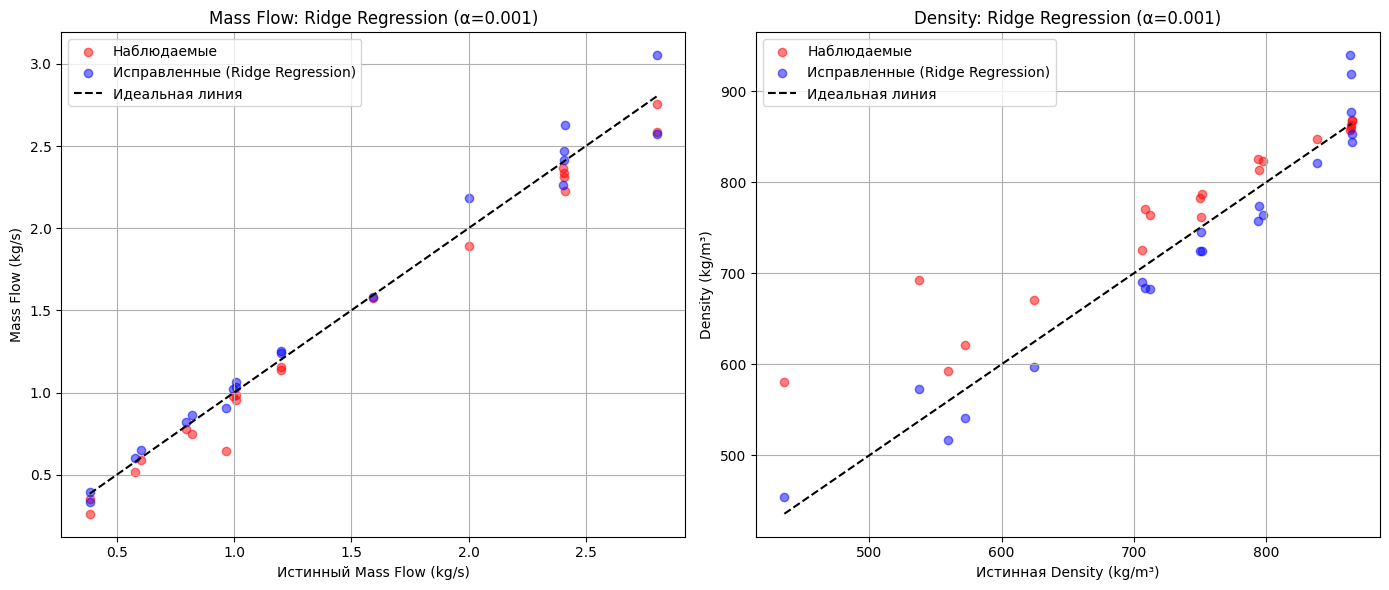


=== Зависимость RMSE от alpha (CV результаты) ===


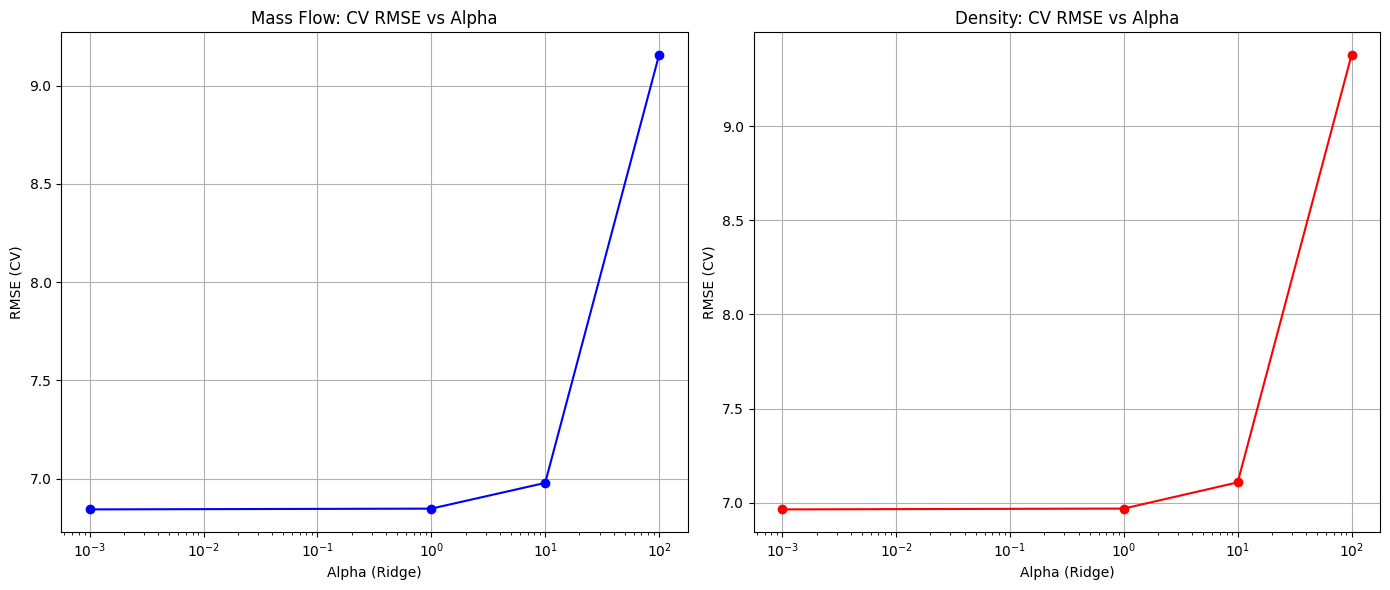


Параметры лучшей модели для использования:
Alpha для Mass Flow: 1.00e-03
Alpha для Density: 1.00e-03
Коэффициенты Mass Flow: [ 5.78912937 -7.90740691]
Перехват Mass Flow: -10.632309434105279
Коэффициенты Density: [-5.68041108  8.40089825]
Перехват Density: 9.338557769943856


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from IPython.display import display
import matplotlib.pyplot as plt



# Подготовка данных
X = df[['Cor Mass Flow [kg/s]', 'Cor Density Drop [%]']].values
y_mf = df['Err Mass Flow [%]'].values
y_rho = df['Err Density [%]'].values
m_obs = df['Cor Mass Flow [kg/s]'].values
m_true = df['Ref Mass Flow [kg/s]'].values
rho_obs = df['Cor Density [kg/m3]'].values
rho_true = df['Ref Density [kg/m3]'].values


# Разбиение данных (80/20) с согласованными индексами
X_train, X_test, y_mf_train, y_mf_test, y_rho_train, y_rho_test, \
m_obs_train, m_obs_test, m_true_train, m_true_test, \
rho_obs_train, rho_obs_test, rho_true_train, rho_true_test = train_test_split(
    X, y_mf, y_rho, m_obs, m_true, rho_obs, rho_true,
    test_size=0.2, random_state=42)

# Нормализация с использованием StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Функция для вычисления метрик с обработкой деления на ноль
def compute_metrics(corrected, true):
    mse = np.mean((corrected - true)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(corrected - true))
    # Избегаем деления на ноль в MAPE
    non_zero_mask = true != 0
    mape = np.mean(np.abs((corrected[non_zero_mask] - true[non_zero_mask]) / true[non_zero_mask])) * 100 if non_zero_mask.any() else np.nan
    return mse, rmse, mae, mape

# 1. Обычная линейная регрессия (без регуляризации)
print("=== Обычная линейная регрессия ===")
lr_mf = LinearRegression()
lr_mf.fit(X_train_norm, y_mf_train)
pred_mf_lr = lr_mf.predict(X_test_norm)
corrected_m_lr = m_obs_test / np.maximum(1 + pred_mf_lr / 100, 1e-10)
mse_m_lr, rmse_m_lr, mae_m_lr, mape_m_lr = compute_metrics(corrected_m_lr, m_true_test)

lr_rho = LinearRegression()
lr_rho.fit(X_train_norm, y_rho_train)
pred_rho_lr = lr_rho.predict(X_test_norm)
corrected_rho_lr = rho_obs_test / np.maximum(1 + pred_rho_lr / 100, 1e-10)
mse_rho_lr, rmse_rho_lr, mae_rho_lr, mape_rho_lr = compute_metrics(corrected_rho_lr, rho_true_test)

# Результаты обычной линейной регрессии
results_lr = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE'],
    'Mass Flow (kg/s)': [mse_m_lr, rmse_m_lr, mae_m_lr, mape_m_lr],
    'Density (kg/m³)': [mse_rho_lr, rmse_rho_lr, mae_rho_lr, mape_rho_lr]
}
results_lr_df = pd.DataFrame(results_lr)
print("Результаты обычной линейной регрессии:")
display(results_lr_df)

# 2. Подбор гиперпараметров с Grid Search + CV
print("\n=== Подбор гиперпараметров (Ridge Regression) ===")

# Расширенный диапазон для alpha
alpha_range = [0.001, 1.0, 10.0, 100.0]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search для Mass Flow
print("Grid Search для Mass Flow...")
ridge_params = {'alpha': alpha_range}
ridge_mf = Ridge()
grid_search_mf = GridSearchCV(ridge_mf, ridge_params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_mf.fit(X_train_norm, y_mf_train)

# Лучшие параметры для Mass Flow
best_alpha_mf = grid_search_mf.best_params_['alpha']
best_ridge_mf = grid_search_mf.best_estimator_
print(f"Лучший alpha для Mass Flow: {best_alpha_mf}")

# Grid Search для Density
print("Grid Search для Density...")
ridge_rho = Ridge()
grid_search_rho = GridSearchCV(ridge_rho, ridge_params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rho.fit(X_train_norm, y_rho_train)

# Лучшие параметры для Density
best_alpha_rho = grid_search_rho.best_params_['alpha']
best_ridge_rho = grid_search_rho.best_estimator_
print(f"Лучший alpha для Density: {best_alpha_rho}")

# 3. Оценка лучшей модели на тестовом и тренировочном наборах
print("\n=== Оценка лучшей модели ===")

# Тестовый набор
pred_mf_ridge = best_ridge_mf.predict(X_test_norm)
corrected_m_ridge = m_obs_test / np.maximum(1 + pred_mf_ridge / 100, 1e-10)
mse_m_ridge, rmse_m_ridge, mae_m_ridge, mape_m_ridge = compute_metrics(corrected_m_ridge, m_true_test)

pred_rho_ridge = best_ridge_rho.predict(X_test_norm)
corrected_rho_ridge = rho_obs_test / np.maximum(1 + pred_rho_ridge / 100, 1e-10)
mse_rho_ridge, rmse_rho_ridge, mae_rho_ridge, mape_rho_ridge = compute_metrics(corrected_rho_ridge, rho_true_test)

# Тренировочный набор
train_pred_mf = best_ridge_mf.predict(X_train_norm)
train_corrected_m = m_obs_train / np.maximum(1 + train_pred_mf / 100, 1e-10)
train_mse_m, train_rmse_m, train_mae_m, train_mape_m = compute_metrics(train_corrected_m, m_true_train)

train_pred_rho = best_ridge_rho.predict(X_train_norm)
train_corrected_rho = rho_obs_train / np.maximum(1 + train_pred_rho / 100, 1e-10)
train_mse_rho, train_rmse_rho, train_mae_rho, train_mape_rho = compute_metrics(train_corrected_rho, rho_true_train)

# Результаты Ridge Regression
results_ridge = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE'],
    'Mass Flow (kg/s)': [mse_m_ridge, rmse_m_ridge, mae_m_ridge, mape_m_ridge],
    'Density (kg/m³)': [mse_rho_ridge, rmse_rho_ridge, mae_rho_ridge, mape_rho_ridge],
    'Train Mass Flow (kg/s)': [train_mse_m, train_rmse_m, train_mae_m, train_mape_m],
    'Train Density (kg/m³)': [train_mse_rho, train_rmse_rho, train_mae_rho, train_mape_rho]
}
results_ridge_df = pd.DataFrame(results_ridge)
print("Результаты Ridge Regression с оптимальными параметрами:")
display(results_ridge_df)

# Сравнение моделей
print("\n=== Сравнение моделей ===")
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression'],
    'RMSE Mass Flow': [rmse_m_lr, rmse_m_ridge],
    'RMSE Density': [rmse_rho_lr, rmse_rho_ridge],
    'MAE Mass Flow': [mae_m_lr, mae_m_ridge],
    'MAE Density': [mae_rho_lr, mae_rho_ridge],
    'MAPE Mass Flow': [mape_m_lr, mape_m_ridge],
    'MAPE Density': [mape_rho_lr, mape_rho_ridge]
})
display(comparison)

# 4. Графики для лучшей модели (Ridge Regression)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mass Flow
ax1.scatter(m_true_test, m_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax1.scatter(m_true_test, corrected_m_ridge, color='blue', label='Исправленные (Ridge Regression)', alpha=0.5)
ax1.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--', label='Идеальная линия')
ax1.set_xlabel('Истинный Mass Flow (kg/s)')
ax1.set_ylabel('Mass Flow (kg/s)')
ax1.set_title(f'Mass Flow: Ridge Regression (α={best_alpha_mf})')
ax1.legend()
ax1.grid(True)

# Density
ax2.scatter(rho_true_test, rho_obs_test, color='red', label='Наблюдаемые', alpha=0.5)
ax2.scatter(rho_true_test, corrected_rho_ridge, color='blue', label='Исправленные (Ridge Regression)', alpha=0.5)
ax2.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--', label='Идеальная линия')
ax2.set_xlabel('Истинная Density (kg/m³)')
ax2.set_ylabel('Density (kg/m³)')
ax2.set_title(f'Density: Ridge Regression (α={best_alpha_rho})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
print("Минимальные значения ошибок:", df[['Err Mass Flow [%]', 'Err Density [%]']].min())
print("Максимальные значения ошибок:", df[['Err Mass Flow [%]', 'Err Density [%]']].max())
print("Нулевые или близкие к нулю:", (df[['Err Mass Flow [%]', 'Err Density [%]']].abs() < 0.1).sum())

Минимальные значения ошибок: Err Mass Flow [%]   -55.908674
Err Density [%]      -1.146379
dtype: float64
Максимальные значения ошибок: Err Mass Flow [%]     0.04406
Err Density [%]      59.15771
dtype: float64
Нулевые или близкие к нулю: Err Mass Flow [%]    3
Err Density [%]      9
dtype: int64
